# Typical use cases in high energy physics

In [1]:
# Imports
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
# Plot settings
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['figure.figsize'] = (10, 7)

## Data model and goals

We consider 1 millions of "observations", each defined by ten 3D vectors $(r_0,...,r_9)$ where $r_i=(x,y,z)$. These pseudo data can represent position in space or RGB colors. This is just an example to play with and apply numpy concepts for both simple computations (element-by-element functions, statistics calculations) and more complex calculations exploiting the multi-dimensional structure of the data. For example, one might want to compute the distance between all pairs $(r_i, r_j)$, which has to be done without loop.

Using the `np.random` module, it is possible to generate n-dimensional arrays easily. In our case, we want to generate pseudo-data as an array containing our observations with have 3 dimensions (or **axis** in `numpy` language), and the size along each of these axis will have the following value and meaning:
  + `axis=0`: over 1 million events
  + `axis=1`: over 10 vectors
  + `axis=2`: over 3 coordinates

In [3]:
r = np.random.random_sample((1000000, 10, 3))
print(r[0:2, ...])

[[[0.11565353 0.18948461 0.62984895]
  [0.42932845 0.32782561 0.27783779]
  [0.56957279 0.0189856  0.25712615]
  [0.70273917 0.95586083 0.26577568]
  [0.58092024 0.91899339 0.70095899]
  [0.25597834 0.28071807 0.34716292]
  [0.2790345  0.88324245 0.52832969]
  [0.65516038 0.80116358 0.09498912]
  [0.25620965 0.84625902 0.25135308]
  [0.34640387 0.29864917 0.30953939]]

 [[0.67849065 0.74025975 0.22319789]
  [0.56300543 0.73642676 0.39249035]
  [0.53774552 0.54752687 0.95504063]
  [0.43430855 0.51938667 0.04538735]
  [0.87616923 0.76191866 0.07106315]
  [0.68232237 0.21571922 0.54843904]
  [0.25458225 0.40148339 0.83364573]
  [0.7959044  0.33925827 0.74188441]
  [0.02103607 0.50218236 0.82084993]
  [0.61883856 0.08677641 0.79843253]]]


## Mean over the differents axis

### Mean over axis=0

This mean will average all observations over the first dimension, returning an array of dimension `(10, 3)` corresponding to the average $r_{i}=(x_i,y_i,z_i)$ over the 1 millions observations. The histogram distribution results into three separate histograms (one for each $x,y,x$) each having 10 entries (one per $r_i$)

32.1 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(10, 3)


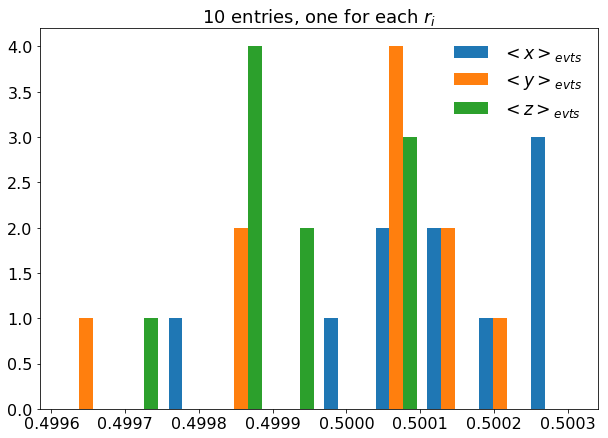

In [4]:
%timeit np.mean(r, axis=0)
m0 = np.mean(r, axis=0)
print(m0.shape)
ax = plt.hist(m0, label=['$<x>_{evts}$', '$<y>_{evts}$', '$<z>_{evts}$'])
ax = plt.title('10 entries, one for each $r_i$')
ax = plt.legend()

### Mean over axis=1

This one will compute the average over the 10 vectors, for each of 1 million observations, reducing into a `(1000000, 3)` shape array, as seen below.

255 ms ± 8.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000000, 3)


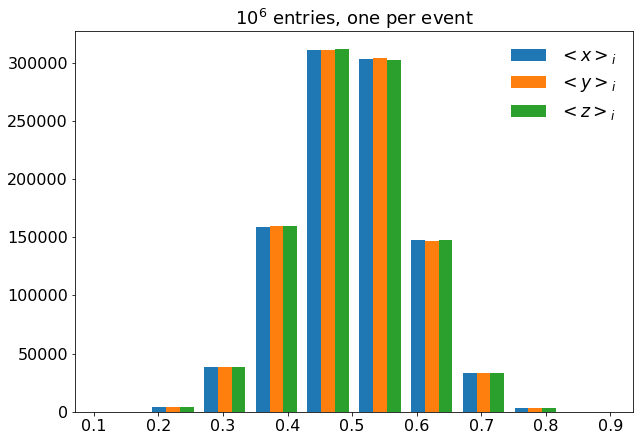

In [5]:
%timeit np.mean(r, axis=1)
m1 = np.mean(r, axis=1)
print(m1.shape)
ax = plt.hist(m1, label=['$<x>_{i}$', '$<y>_{i}$', '$<z>_{i}$'])
ax = plt.title('$10^6$ entries, one per event')
ax = plt.legend()

### Mean over axis=2

This directly computes the average over the three coordinates for each vector of each event, in other words, the barycenter $(x+y+z)/3$.

202 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000000, 10)


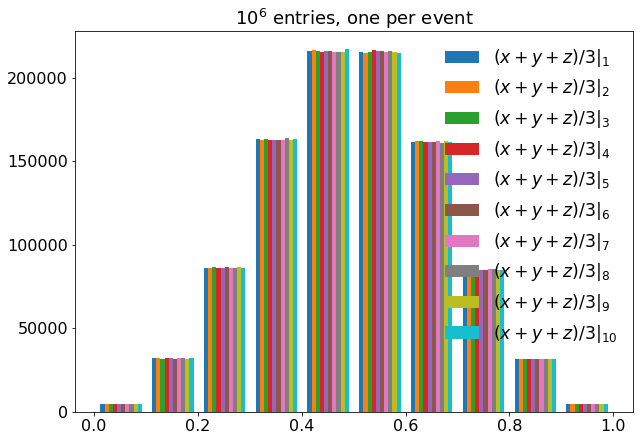

In [6]:
%timeit np.mean(r, axis=2)
m2 = np.mean(r, axis=2)
print(m2.shape)
ax = plt.hist(m2, label=['$(x+y+z)/3|_{'+'{}'.format(i)+'}$' for i in range(1, 11)])
ax = plt.title('$10^6$ entries, one per event')
ax = plt.legend()

## Distance computation

### Distance to a reference $r_0$

404 ms ± 9.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000000, 10)


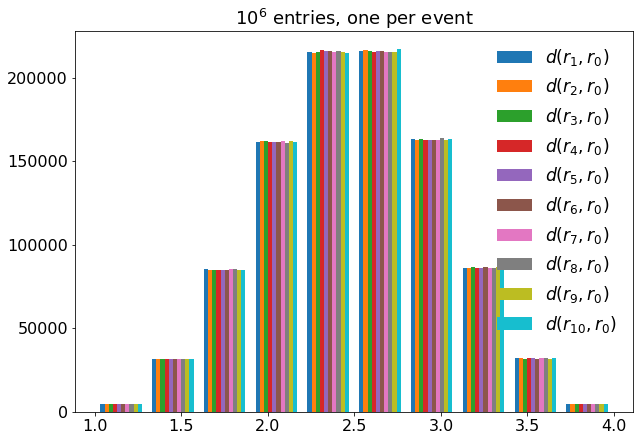

In [7]:
# Reference definition 
r0 = np.array([1, 2, 1])

# Compute all 10 differences for all the events
%timeit np.sum(((r-r0)**2)**0.5, axis=2)
d = np.sum(((r-r0)**2)**0.5, axis=2)
print(d.shape)
ax = plt.hist(d, label=['$d(r_{'+'{}'.format(i)+'},r_0)$' for i in range(1, 11)])
ax = plt.title('$10^6$ entries, one per event')
ax = plt.legend()

### Distance between the two first vectors $r_0$ and $r_1$ for each event

52.8 ms ± 3.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000000,)


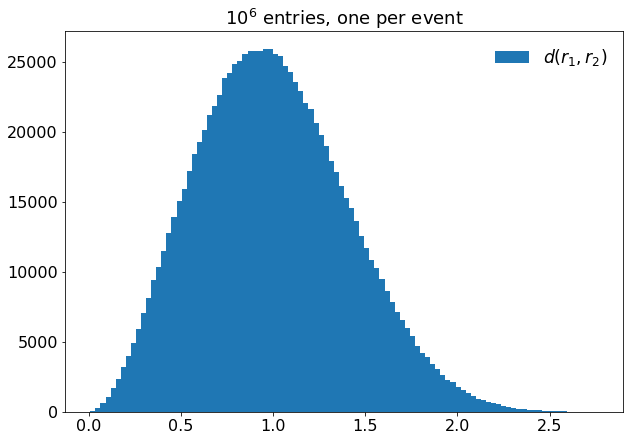

In [8]:
# Condensed expression
%timeit np.sum(((r[:, 0, :]-r[:, 1, :])**2)**0.5, axis=1)

# More readable expression
r1, r2 = r[:, 0, :], r[:, 1, :]
d12 = np.sum(((r1-r2)**2)**0.5, axis=1)
print(d12.shape)

# Plotting
ax = plt.hist(d12, label='$d(r_1,r_2)$', bins=100)
ax = plt.title('$10^6$ entries, one per event')
ax = plt.legend()

## Pairing 3D vectors for each observation, without a loop

### Finding all possible $(r_{i}, r_{j})$ pairs for all events

In [9]:
def combs_nd(a, n, axis=0, info=False):
    '''
    Solution found on https://stackoverflow.com/questions/16003217/n-d-version-of-itertools-combinations-in-numpy
    
    The idea here is to simply work on indices to build the pairs 
    since it doesn't really matter what are the nature of the objects ...
    '''

    # 1. Initialisation of indices array along the axis we want to pair
    indices = np.arange(a.shape[axis])
    if info:
        print('initialisation -> indices={}'.format(indices))
        
    # 2. Datatype of index array ([int,int] for a pair)
    dt = np.dtype([('', np.intp)]*n)
    if info:
        print('datatype: {}'.format(dt))
    
    # 3. Use itertool to compute combinations and overwite indices
    indices = np.fromiter(itertools.combinations(indices, n), dt) # [(0,1), (0,2), .. ]
    if info:
        print('np.fromiter -> indicies={}'.format(indices))
    indices = indices.view(np.intp) # [0 1 0 2 ...]
    if info:
        print('indices.view -> indicies={}'.format(indices))
    indices = indices.reshape(-1, n) # [[0 1], [0 2], ...]
    if info:
        print('indices.reshape -> indicies={}'.format(indices))
        
    # 4. Take all elements in a defined by indices along a given axis
    # the dimension of the array is changed because indices has (n,2) shape
    return np.take(a, indices, axis=axis)


# Trying on the 2 first observations considering only the 5 first vectors ri: r[0:1, 0:5]
result = combs_nd(a=r[0:1,0:5], n=2, axis=1, info=True)

initialisation -> indices=[0 1 2 3 4]
datatype: [('f0', '<i8'), ('f1', '<i8')]
np.fromiter -> indicies=[(0, 1) (0, 2) (0, 3) (0, 4) (1, 2) (1, 3) (1, 4) (2, 3) (2, 4) (3, 4)]
indices.view -> indicies=[0 1 0 2 0 3 0 4 1 2 1 3 1 4 2 3 2 4 3 4]
indices.reshape -> indicies=[[0 1]
 [0 2]
 [0 3]
 [0 4]
 [1 2]
 [1 3]
 [1 4]
 [2 3]
 [2 4]
 [3 4]]


### Computing (minimum) distances on these pairs

In [10]:
# Time and get the pair function
print('\nGetting all pairs')
%timeit combs_nd(r, 2, axis=1)
pairs = combs_nd(r, 2, axis=1)
print(pairs.shape)

# Time and Get the euclidien distance of all pair
print('\nGetting all euclidian distances')
dp = pairs[:, :, 0, :]-pairs[:, :, 1, :]
%timeit(np.sum(dp**2, axis=2))**0.5
diff_pairs = (np.sum(dp**2, axis=2))**0.5
print(dp.shape)
print(diff_pairs.shape)

# Time and get the minimum
print('\nGetting the minimum distances')
%timeit np.min(diff_pairs, axis=1)
closest_pair = np.min(diff_pairs, axis=1)
print(closest_pair.shape)


Getting all pairs
870 ms ± 35.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000000, 45, 2, 3)

Getting all euclidian distances
1.09 s ± 40.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000000, 45, 3)
(1000000, 45)

Getting the minimum distances
69.1 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000000,)


In [11]:
def compute_dr_min(a):
    pairs = combs_nd(a, 2, axis=1)
    
    # Get the axis of the pair index to build p1, p2 = a[...,0], a[...,1]
    d = pairs.ndim
    i1 = tuple([None if i != d-2 else 0 for i in range(0, d)])
    i2 = tuple([None if i != d-2 else 1 for i in range(0, d)])
    
    return np.min(np.sum((pairs[i1]-pairs[i2])**2, axis=2)**0.5, axis=1)


# Time and get the minimum from r directly
print('\nGetting the minimum distances from r directly using one function')
%timeit compute_dr_min(r)


Getting the minimum distances from r directly using one function
838 ms ± 9.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


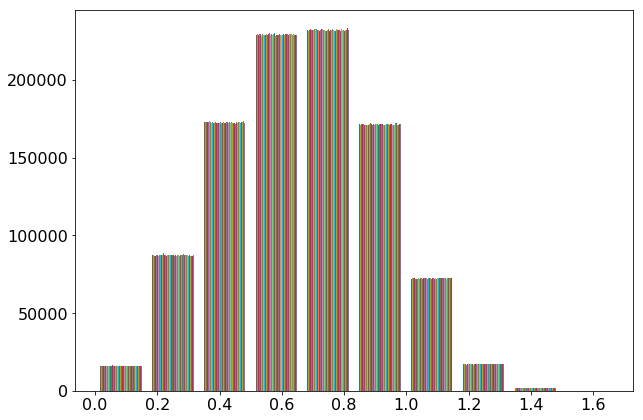

In [12]:
ax = plt.hist(diff_pairs)

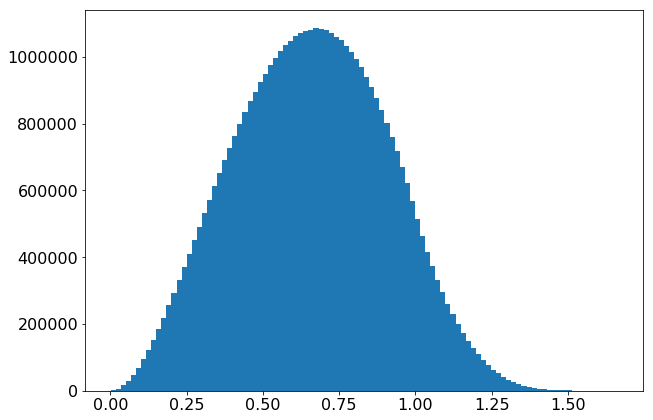

In [13]:
ax = plt.hist(diff_pairs.flatten(), bins=100)

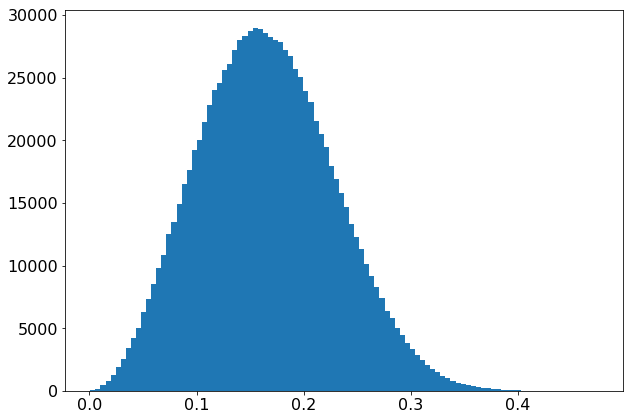

In [14]:
ax = plt.hist(closest_pair, bins=100)

## Selecting a subset of $r_i$ based on $(x,y,z)$ values, without loop

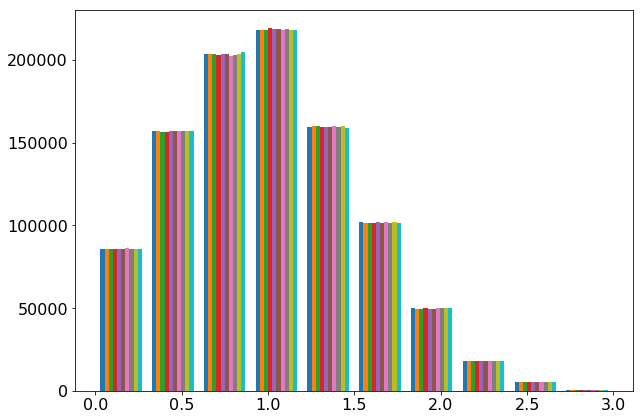

In [15]:
x, y, z = r[:, :, 0], r[:, :, 1], r[:, :, 2]
ax = plt.hist(x**2+y**2+z**2, bins=10)

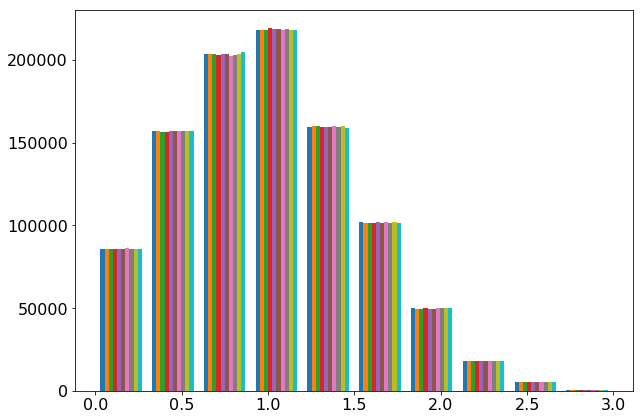

In [16]:
ax = plt.hist(np.sum(r**2, axis=2), bins=10)

### Counting number of points amont the 10 with $x_i>y_i$ in each event

(1000000, 10)


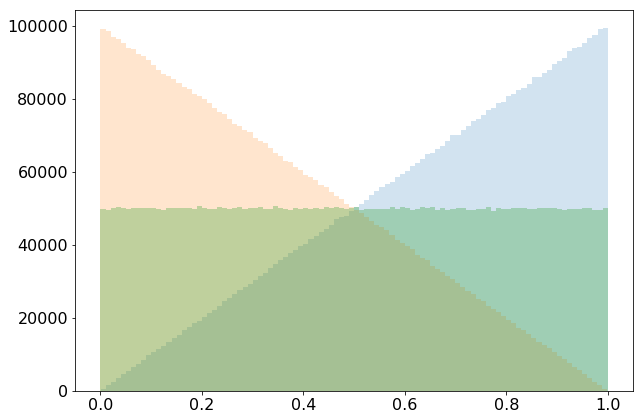

In [17]:
# define the selection
idx = x > y
print(idx.shape)

# Checkout the distribution of x,y,z for the selected points
ax = plt.hist(x[idx], bins=100, alpha=0.2)
ax = plt.hist(y[idx], bins=100, alpha=0.2)
ax = plt.hist(z[idx], bins=100, alpha=0.3)

(1000000,)


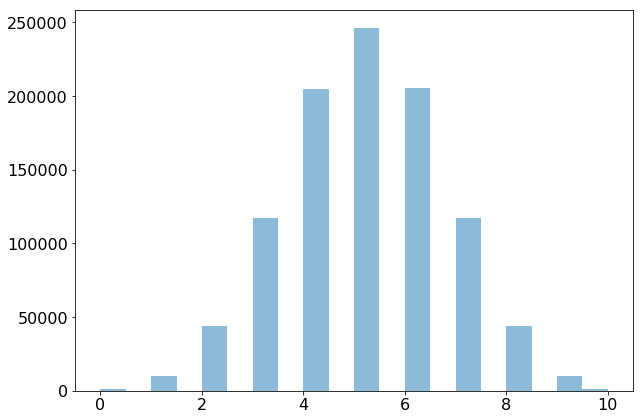

In [18]:
# Count the number of r per event satisfying x>y
c = np.count_nonzero(idx, axis=1)
print(c.shape)

# Plot the distribution of the count
ax = plt.hist(c, bins=20, alpha=0.5)

### Plotting $z$ for the two types of population  ($x>y$ and $x<y$)


 -> Full array shape    = (500, 10)
 -> Indexed array shape = (2511,)
 -> Counting *all* selected pairs: 2511


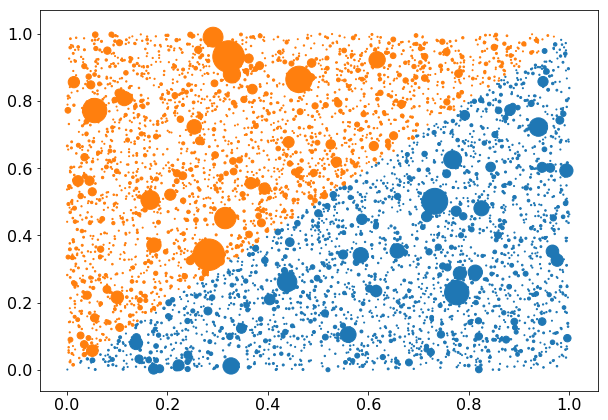

In [19]:
# Access xi and yi which satisfy xi>yi and xi<xi for each events (over 500 events)
# using proper indexing
sx, sy, sz = x[0:500, ...], y[0:500, ...], z[0:500, ...]
sidx_gt, sidx_lt = sx > sy, sx < sy

# Taking the proper indexing will flatten the array
print('\n -> Full array shape    = {}'.format(sx.shape))
print(' -> Indexed array shape = {}'.format(sx[sidx_gt].shape))
print(' -> Counting *all* selected pairs: {}'.format(np.count_nonzero(sidx_gt)))

# Plotting x vs z for the two populations (marker size is 1/(z+0.001))
ax = plt.scatter(sx[sidx_gt], sy[sidx_gt], s=(sz[sidx_gt]+1e-3)**-1)
ax = plt.scatter(sx[sidx_lt], sy[sidx_lt], s=(sz[sidx_lt]+1e-3)**-1)

### Compute $x_i+y_i+z_i$ sum over  the collection of 10 $r_i$ including only points that have $x_i>y_i$ ?

(1000000,)
(1000000, 10) (1000000, 10) (1000000,)


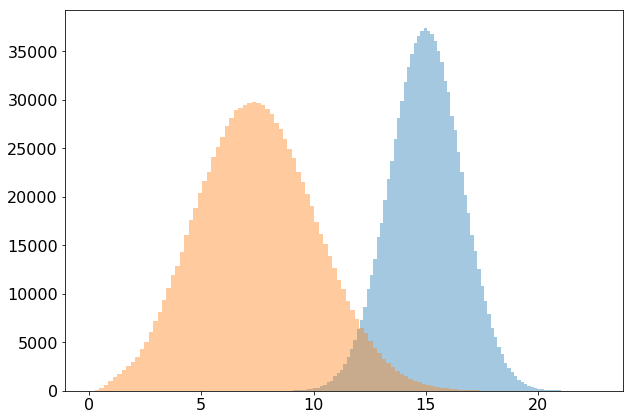

In [20]:
# First step: basic sum over 10 points, ie sum_{i=1..10}(xi+yi+zi) for each event.
ht1 = np.sum(x+y+z, axis=1)
print(ht1.shape)
ax = plt.hist(ht1, bins=100, alpha=0.4)

# Second step: doing the proper sum, ie only with points verifying x>y.
# 'x*selection' replace xi by 0 in [x0,...,x9]_evt where x<y for all 
# events evt. They must have the same shape to be multiplied element 
# by element.
selection = x>y 
ht2 = np.sum((x+y+z)*selection, axis=1) 
print(x.shape, selection.shape, ht2.shape)
ax = plt.hist(ht2[ht2 > 0], bins=100, alpha=0.4)

### Pairing with a subset of $r_i$ verifying $x_i>y_i$ only

In [21]:
# define index of selected points
selection = x > y

# add an empty dimension to make broadcasting possible
selected_r = r*selection[:, :, None]

# replace all 0 (False) by nan so that any combinaison with one of those 
# will be nan - and be filtered
selected_r[selected_r == 0] = np.nan

# Print the two first events
print(selected_r[:2])

[[[       nan        nan        nan]
  [0.42932845 0.32782561 0.27783779]
  [0.56957279 0.0189856  0.25712615]
  [       nan        nan        nan]
  [       nan        nan        nan]
  [       nan        nan        nan]
  [       nan        nan        nan]
  [       nan        nan        nan]
  [       nan        nan        nan]
  [0.34640387 0.29864917 0.30953939]]

 [[       nan        nan        nan]
  [       nan        nan        nan]
  [       nan        nan        nan]
  [       nan        nan        nan]
  [0.87616923 0.76191866 0.07106315]
  [0.68232237 0.21571922 0.54843904]
  [       nan        nan        nan]
  [0.7959044  0.33925827 0.74188441]
  [       nan        nan        nan]
  [0.61883856 0.08677641 0.79843253]]]


In [22]:
pairs = combs_nd(selected_r, n=2, axis=1)  # get all the possible pairs
print(pairs.shape)

(1000000, 45, 2, 3)


In [23]:
# get the first and second element of the pair
p1, p2 = pairs[:, :, 0, :], pairs[:, :, 1, :]

# compute the distance (summed over x,y,z, is axis=2)
dp = np.sum((p1-p2)**2, axis=2)**0.5

# set a default value of irrelevant pairs
dp[np.isnan(dp)] = 999
print(dp.shape)

(1000000, 45)


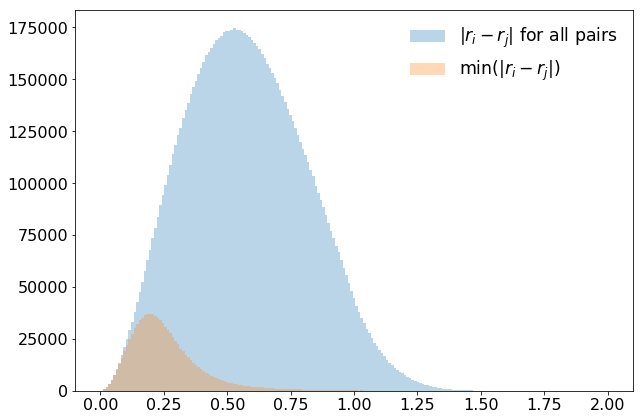

In [24]:
ax = plt.hist(dp.flatten(), bins=np.linspace(0, 2, 200), alpha=0.3, label='$|r_i-r_j|$ for all pairs')
ax = plt.hist(np.min(dp, axis=1), bins=np.linspace(0, 2, 200), alpha=0.3, label='min$(|r_i-r_j|)$')
ax = plt.legend()

## Play with two collections of vectors with different size $\{r_i\}_{10}$ and $\{q_i\}_6$

In [25]:
q = np.random.random_sample((1000000, 6, 3))
print(q[0:2])

[[[0.72846976 0.36453197 0.01145192]
  [0.35419366 0.12872047 0.88346129]
  [0.8832149  0.07994779 0.73534333]
  [0.69584834 0.53609698 0.52243828]
  [0.36197157 0.02261003 0.87612184]
  [0.34844683 0.83137148 0.77408195]]

 [[0.23096686 0.7873199  0.48843201]
  [0.47783539 0.79411894 0.60524871]
  [0.23530117 0.42049234 0.80970652]
  [0.67694867 0.48655929 0.62385231]
  [0.10215222 0.51858284 0.77035387]
  [0.81167546 0.91135836 0.90273964]]]


In [26]:
def all_pairs_nd(a, b, axis=0):

    # Sanity check
    good_shape = np.array_equal(
        np.delete(a.shape, axis), np.delete(b.shape, axis))
    if not good_shape:
        err = 'The shape along all dimensions but the one of axis={}'.format(
            axis)
        err += ' should be equal, while here:\n'
        err += '  -> shape of a is {} \n'.format(a.shape)
        err += '  -> shape of b is {} \n'.format(b.shape)
        raise NameError(err)

    # Individual indices
    a, b = np.asarray(a), np.asarray(b)
    ia, jb = np.arange(a.shape[axis]), np.arange(b.shape[axis])

    # Pairs of indicies
    dt = np.dtype([('', np.intp)]*2)
    if np.array_equal(a, b):
        ij = np.fromiter(itertools.combinations(ia, 2), dtype=dt)
    else:
        ij = np.fromiter(itertools.product(ia, jb), dtype=dt)
    ij = ij.view(np.intp).reshape(-1, 2)

    # Array of all pairs
    ipair, jpair = ij[:, 0], ij[:, 1]
    return np.stack([a.take(ipair, axis=axis), b.take(jpair, axis=axis)], axis=axis+1)

In [27]:
p = all_pairs_nd(r, q, axis=1)
print(p.shape)

(1000000, 60, 2, 3)


In [28]:
pairs = all_pairs_nd(r, r, axis=1)
print(pairs.shape)

(1000000, 45, 2, 3)


In [29]:
# Case where it will crash
p = all_pairs_nd(r, q, axis=2)

NameError: The shape along all dimensions but the one of axis=2 should be equal, while here:
  -> shape of a is (1000000, 10, 3) 
  -> shape of b is (1000000, 6, 3) 


## Supplement: explanation of `all_pairs_nd(a,b,axis)`

In [30]:
axis = 1

a = np.array([
    [[1, 2], [3, 4]],
    [[5, 6], [7, 8]]
])

b = np.array([
    [[9, 10], [11, 12], [13, 14]],
    [[15, 16], [17, 18], [19, 20]]
])

In [31]:
a

array([[[1, 2],
        [3, 4]],

       [[5, 6],
        [7, 8]]])

In [32]:
b

array([[[ 9, 10],
        [11, 12],
        [13, 14]],

       [[15, 16],
        [17, 18],
        [19, 20]]])

In [33]:
# Get the indices of all pairs
ia, jb = np.arange(a.shape[axis]), np.arange(b.shape[axis])
dt = np.dtype([('', np.intp)]*2)
ij = np.fromiter(itertools.product(ia, jb), dtype=dt)
print(ij)
ij = ij.view(np.intp)
print(ij)
ij = ij.reshape(-1, 2)
print(ij)

[(0, 0) (0, 1) (0, 2) (1, 0) (1, 1) (1, 2)]
[0 0 0 1 0 2 1 0 1 1 1 2]
[[0 0]
 [0 1]
 [0 2]
 [1 0]
 [1 1]
 [1 2]]


In [34]:
ipair = ij[:, 0]  # fisrt element of ij is the index of a
pairs_a = np.take(a, ipair, axis=1)
pairs_a

array([[[1, 2],
        [1, 2],
        [1, 2],
        [3, 4],
        [3, 4],
        [3, 4]],

       [[5, 6],
        [5, 6],
        [5, 6],
        [7, 8],
        [7, 8],
        [7, 8]]])

In [35]:
jpair = ij[:, 1]  # second element of ij is the index of b
pairs_b = np.take(b, jpair, axis=1)
pairs_b

array([[[ 9, 10],
        [11, 12],
        [13, 14],
        [ 9, 10],
        [11, 12],
        [13, 14]],

       [[15, 16],
        [17, 18],
        [19, 20],
        [15, 16],
        [17, 18],
        [19, 20]]])

In [36]:
pairs = np.stack([pairs_a, pairs_b], axis=2)
print(pairs.shape)
pairs

(2, 6, 2, 2)


array([[[[ 1,  2],
         [ 9, 10]],

        [[ 1,  2],
         [11, 12]],

        [[ 1,  2],
         [13, 14]],

        [[ 3,  4],
         [ 9, 10]],

        [[ 3,  4],
         [11, 12]],

        [[ 3,  4],
         [13, 14]]],


       [[[ 5,  6],
         [15, 16]],

        [[ 5,  6],
         [17, 18]],

        [[ 5,  6],
         [19, 20]],

        [[ 7,  8],
         [15, 16]],

        [[ 7,  8],
         [17, 18]],

        [[ 7,  8],
         [19, 20]]]])